# **MIE1624 Project : Sentiment Analysis on Russia-Ukraine War**


> Group 6


> Zhimeng Cao, Leon Ip, Lu Jiang, Yifan Liu, Jingyi Nie, Haizheng Sun






In [ ]:
!pip install eli5

In [ ]:
!pip install vaderSentiment

In [ ]:
!pip3 install flair

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

import requests
from PIL import Image
from io import BytesIO
import re
import string
import eli5
import flair
from wordcloud import WordCloud
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import warnings
warnings.simplefilter('ignore')

In [ ]:
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
nltk.download('stopwords')
stop = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Sentiment modeling

In [ ]:
tweet = pd.read_csv('sentiment_analysis.csv')
df = tweet.copy()

In [ ]:
# Check the total number of negative and positive tweets
tweet.label.value_counts()

1    371341
0    179050
Name: label, dtype: int64

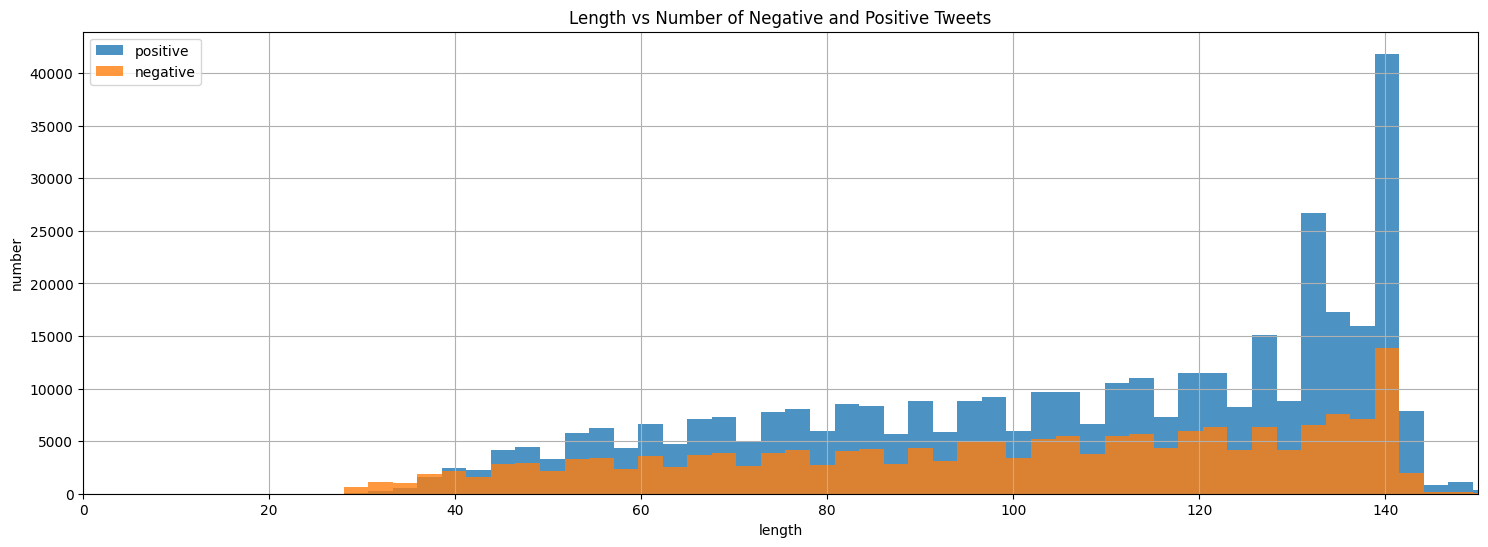

In [ ]:
tweet['length'] = tweet['text'].apply(lambda x: len(x))
# Plot the length vs number of negative and positive tweets
plt.figure(figsize=(18,6))
plt.hist(tweet[tweet['label']==1]['length'], alpha=0.8, bins=50, label='positive')
plt.hist(tweet[tweet['label']==0]['length'], alpha=0.8, bins=50, label='negative')
plt.xlabel('length')
plt.ylabel('number')
plt.title('Length vs Number of Negative and Positive Tweets')
plt.legend()
plt.xlim(0, 150)
plt.grid()
plt.show()

## Data cleaning

In [ ]:
def clean_data(df):
  # remove urls
  url = re.compile(r'https?://\S+|www\.\S+')
  df['text'] = df['text'].apply(lambda x : url.sub(r'',x))
  # remove emojis
  emoji = re.compile("[" u"\U0001F600-\U0001F64F"  # emoticons
                     u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                     u"\U0001F680-\U0001F6FF"  # supplemental symbols
                     u"\U0001F900-\U0001F9FF"  # transport & map symbols
                     u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                     u"\U00002702-\U000027B0"
                     u"\U000024C2-\U0001F251"
                     "]+", flags=re.UNICODE)
  df['text'] = df['text'].apply(lambda x: emoji.sub(r'',x))
  # remove @
  at = re.compile(r'@[A-Za-z0-9-_]+', re.DOTALL)
  df['text'] = df['text'].apply(lambda x : at.sub(r'',x))
  # remove re-tweet
  rt = re.compile('RT ')
  df['text'] = df['text'].apply(lambda x : rt.sub(r'',x,count=1))
  # convert & to and
  amp = re.compile('&amp')
  df['text'] = df['text'].apply(lambda x : amp.sub(r'and',x))
  # remove punctuations
  table = str.maketrans('', '', string.punctuation)
  df['text'] = df['text'].apply(lambda x : x.translate(table))
  # convert to lowercase
  df['text'] = df['text'].apply(lambda x: " ".join(x.lower() for x in x.split()))
  # remove stop words
  df['text'] = df['text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
  # remove advertisement
  df = df.drop(df[df['text'].str.contains('found transponder')].index)
  return df

In [ ]:
df = clean_data(df)

In [ ]:
tweet.text[453534]

'@UnboxTherapy enjoying Angry Birds 2 😀👌 https://t.co/RAR55qacTM'

In [ ]:
df.text[453534]

'enjoying angry birds 2'

## Wordclouds

In [ ]:
def plot_word_cloud(df, label):
  corpus = []
  for x in df[df['label']==label]['text'].str.split():
    for i in x:
      corpus.append(i)
  plt.figure(figsize=(12,8))
  word_cloud = WordCloud(background_color='black',max_font_size=60,collocations=False).generate(" ".join(corpus))
  plt.imshow(word_cloud)
  plt.axis('off')
  plt.show()

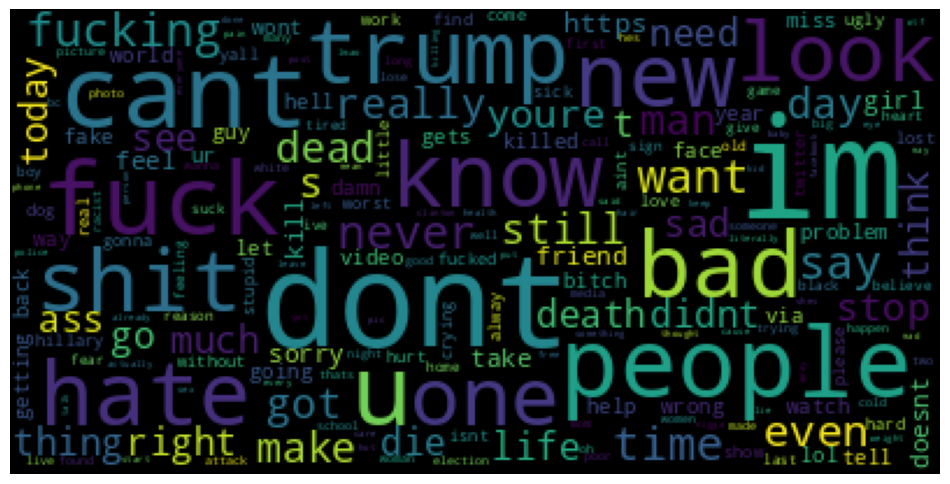

In [ ]:
plot_word_cloud(df, 0)

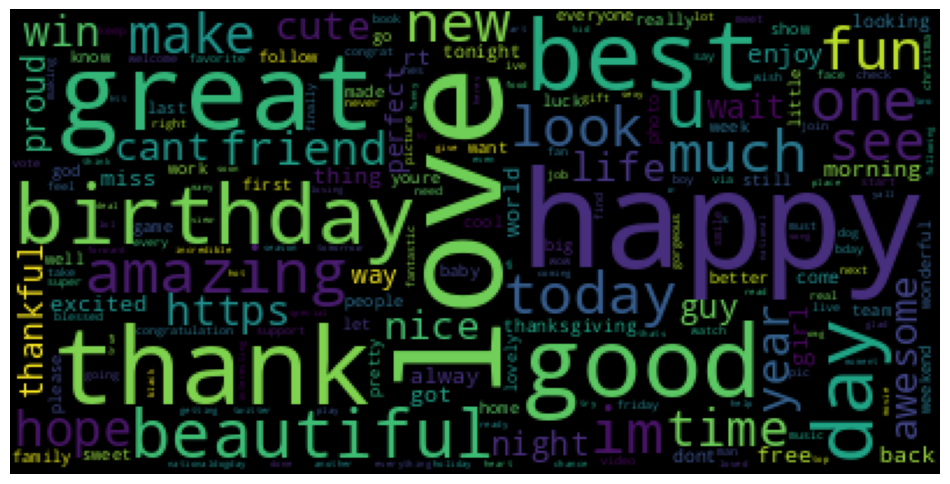

In [ ]:
plot_word_cloud(df, 1)

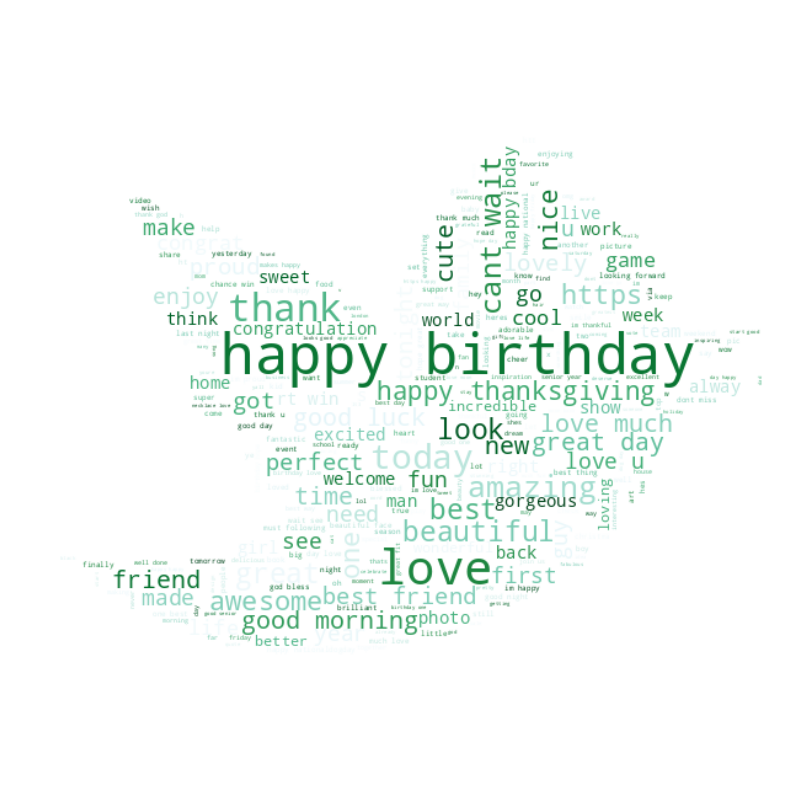

In [ ]:
positive_corpus = []
for x in df[df['label']==1]['text'].str.split():
  for i in x:
    positive_corpus.append(i)

url="https://user-images.githubusercontent.com/74188336/142692890-641ebc21-2e47-4556-9d37-1c0b9e1a0587.jpeg"
response = requests.get(url)
img = Image.open(BytesIO(response.content))
mask = np.array(img)
wordcloud = WordCloud(max_font_size=50, max_words=1000, background_color="white",
                      mask=mask, colormap='BuGn').generate(" ".join(positive_corpus))
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

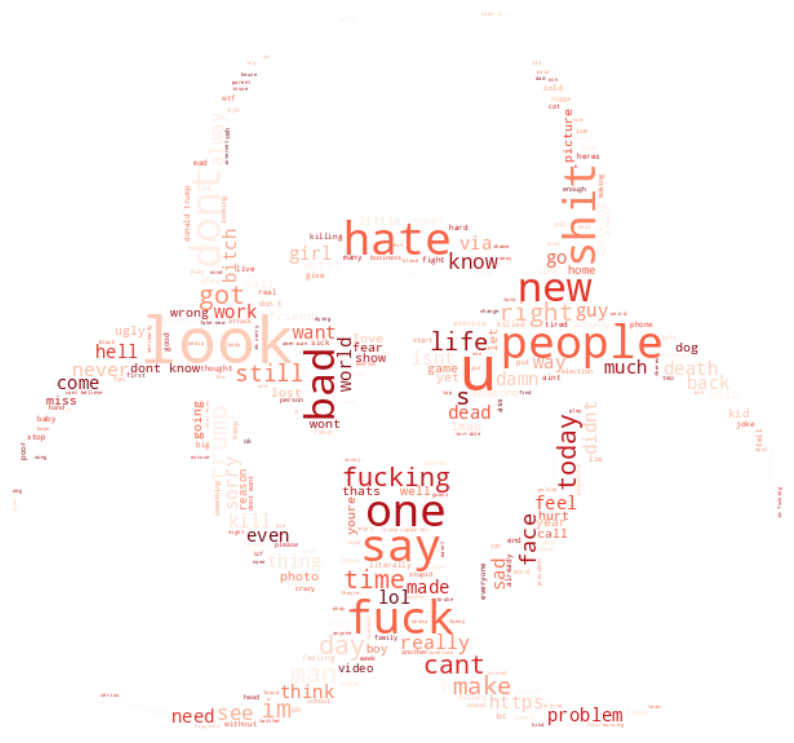

In [ ]:
negative_corpus = []
for x in df[df['label']==0]['text'].str.split():
  for i in x:
    negative_corpus.append(i)

url="https://user-images.githubusercontent.com/74188336/142692894-c17240e4-1101-4591-9d10-71793e460816.jpeg"
response = requests.get(url)
img = Image.open(BytesIO(response.content))
mask = np.array(img)
wordcloud = WordCloud(max_font_size=50, max_words=1000, background_color="white",
                      mask=mask, contour_width=0, contour_color='grey', colormap='Reds').generate(" ".join(negative_corpus))
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Feature Engineering using TF-IDF

In [ ]:
X = df['text']
y = df['label']
# Split to training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1624)

According to various studies and analyses, the most frequent 100 words in English make up about 50% of all written and spoken English, while the most frequent 1,000 words make up approximately 80-85% of all English usage. The most frequent 2,000-3,000 words cover around 90-95% of English usage. In this project we will use 1,000 features.

In [ ]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1,3), max_features=1000)
# Using TF-IDF as the feature engineering technique
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train.values.tolist())
X_test_tfidf = tfidf_vectorizer.transform(X_test.values.tolist())

## Logistic Regression

In [ ]:
logistic_model = LogisticRegression()
param_grid = {'C':[0.1, 1, 5, 10], 'solver':['liblinear', 'saga']}
grid = GridSearchCV(logistic_model, param_grid, cv=5, scoring='accuracy', return_train_score=True)
grid.fit(X_train_tfidf, y_train)
print('The best hyperparameters are:', grid.best_params_)

The best hyperparameters are: {'C': 10, 'solver': 'liblinear'}


In [ ]:
logistic_model = LogisticRegression(penalty='l2', C=10, solver='liblinear')
logistic_score = cross_val_score(logistic_model, X_train_tfidf, y_train, cv=5)
print("Cross-Validation on Logistic Regression: Mean Accuracy: {0}, Variance of Accuracies {1}".format(
    np.mean(logistic_score), np.var(logistic_score)))

Cross-Validation on Logistic Regression: Mean Accuracy: 0.934071259454068, Variance of Accuracies 5.811474421943002e-07


In [ ]:
logistic_model.fit(X_train_tfidf, y_train)
pred_test = logistic_model.predict(X_test_tfidf)
test_accuracy = accuracy_score(y_test, pred_test)
print("The Testing Accuracy of Logistic Regression model: " + str(test_accuracy))

The Testing Accuracy of Logistic Regression model: 0.9337262325503325


The logistic regression model has a mean cross-validation accuracy of 93.4%, and the final testing accuracy is 93.37%.

##  Decision Tree

In [ ]:
dt_model = DecisionTreeClassifier(max_depth=100)
param_grid = {'max_depth':[10, 50, 100], 'splitter':['best', 'random']}
grid = GridSearchCV(dt_model, param_grid, cv=5, scoring='accuracy', return_train_score=True)
grid.fit(X_train_tfidf, y_train)
print('The best hyperparameters are:', grid.best_params_)

The best hyperparameters are: {'max_depth': 100, 'splitter': 'best'}


In [ ]:
dt_model = DecisionTreeClassifier(max_depth=100, splitter='best')
dt_score = cross_val_score(dt_model, X_train_tfidf, y_train, cv=5)
print("Cross-Validation on Decision Tree: Mean Accuracy: {0}, Variance of Accuracies {1}".format(
    np.mean(dt_score), np.var(dt_score)))

Cross-Validation on Decision Tree: Mean Accuracy: 0.9135746061247371, Variance of Accuracies 2.547598467892858e-07


In [ ]:
dt_model.fit(X_train_tfidf, y_train)
pred_test = dt_model.predict(X_test_tfidf)
test_accuracy = accuracy_score(y_test, pred_test)
print("The Testing Accuracy of Decision Tree model: " + str(test_accuracy))

The Testing Accuracy of Decision Tree model: 0.9137424582933129


The decision tree model has a mean cross-validation accuracy of 91.357%, and the final testing accuracy is 91.374%.

## Random Forest

In [ ]:
rf_model = RandomForestClassifier()
param_grid = {'max_depth':[10, 50, 100], 'n_estimators':[5, 10]}
grid = GridSearchCV(rf_model, param_grid, cv=5, scoring='accuracy', return_train_score=True)
grid.fit(X_train_tfidf, y_train)
print('The best hyperparameters are:', grid.best_params_)

The best hyperparameters are: {'max_depth': 100, 'n_estimators': 10}


In [ ]:
rf_model = RandomForestClassifier(n_estimators=10, max_depth=100)
rf_score = cross_val_score(rf_model, X_train_tfidf, y_train, cv=5)
print("Cross-Validation on Random Forest: Mean Accuracy: {0}, Variance of Accuracies {1}".format(
    np.mean(rf_score), np.var(rf_score)))

Cross-Validation on Random Forest: Mean Accuracy: 0.9126630724581775, Variance of Accuracies 2.245613859293523e-06


In [ ]:
rf_model.fit(X_train_tfidf, y_train)
pred_test = rf_model.predict(X_test_tfidf)
test_accuracy = accuracy_score(y_test, pred_test)
print("The Testing Accuracy of Random Forest model: " + str(test_accuracy))

The Testing Accuracy of Random Forest model: 0.9110008672379869


The random forest model has a mean cross-validation accuracy of 91.266%, and the final testing accuracy is 91.1%.

## Multi-layer Perceptron

In [ ]:
mlp_model = MLPClassifier()
param_grid = {'hidden_layer_sizes':[(100), (100,10)], 'activation':['relu', 'tanh']}
grid = GridSearchCV(mlp_model, param_grid, cv=5, scoring='accuracy', return_train_score=True)
grid.fit(X_train_tfidf, y_train)
print('The best hyperparameters are:', grid.best_params_)

The best hyperparameters are: {'hidden_layer_sizes': (100,10), 'activation': 'relu'}


In [ ]:
mlp_model = MLPClassifier(hidden_layer_sizes=(100, 10), activation='relu', solver='adam')
mlp_score = cross_val_score(mlp_model, X_train_tfidf, y_train, cv=3)
print("Cross-Validation on Multi-layer Perceptron: Mean Accuracy: {0}, Variance of Accuracies {1}".format(
    np.mean(mlp_score), np.var(mlp_score)))

Cross-Validation on Multi-layer Perceptron: Mean Accuracy: 0.9310056226508377, Variance of Accuracies 5.792281576380741e-07


In [ ]:
mlp_model.fit(X_train_tfidf, y_train)
pred_test = mlp_model.predict(X_test_tfidf)
test_accuracy = accuracy_score(y_test, pred_test)
print("The Testing Accuracy of Multi-layer Perceptron model: " + str(test_accuracy))

The Testing Accuracy of Multi-layer Perceptron model: 0.9325978906534126


The multi-layer perceptron model has a mean cross-validation accuracy of 93.1%, and the final testing accuracy is 93.26%.

The most positive and negative words of the logistic regression model.

In [ ]:
eli5.show_weights(logistic_model, feature_names=tfidf_vectorizer.get_feature_names_out(), top=(10,10))

# Sentiment classification and Visualization

## Tweets of Elon Musk

Apply the trained sentiment classification model from Part 1 along with other pre-trained classification models to Elon Musk's tweet about Russia’s war in Ukraine.

In [ ]:
tw = pd.read_csv('tw.csv')
tw = clean_data(tw)

In [ ]:
tw_text = tw['text'].values.tolist()
tw_tfidf = tfidf_vectorizer.transform(tw_text)
model_pred = logistic_model.predict(tw_tfidf)
tw_pred = pd.DataFrame(list(zip(tw_text, model_pred)),columns=['text', 'model_pred'])

VADER (Valence Aware Dictionary and Sentiment Reasoner) is a lexicon and rule-based sentiment analysis tool that is specifically designed to detect sentiments expressed in social media.

In [ ]:
def sentiment_vader(sentence):
  sid_obj = SentimentIntensityAnalyzer()
  sentiment_dict = sid_obj.polarity_scores(sentence)
  compound = sentiment_dict['compound']
  if compound >= 0:
    overall_sentiment = 1
  else :
    overall_sentiment = 0
  return overall_sentiment

In [ ]:
# test the pre-trained sentiment model on the original dataset
sampled_data = df.sample(frac=0.01)
sampled_vader_pred = sampled_data['text'].apply(sentiment_vader)
accuracy_score(sampled_data['label'], sampled_vader_pred)

0.8550913838120104

The VADER model has a 85.65% accuracy in the training set.

In [ ]:
vader_pred = tw['text'].apply(sentiment_vader)
tw_pred['vader_pred'] = vader_pred

TextBlob is a Python library for processing textual data. It provides a simple API for diving into common natural language processing (NLP) tasks such as part-of-speech tagging, noun phrase extraction, sentiment analysis, classification, translation, and more.

In [ ]:
def sentiment_texblob(sentence):
  classifier = TextBlob(sentence)
  polarity = classifier.sentiment.polarity
  if polarity >= 0:
    overall_sentiment = 1
  else :
    overall_sentiment = 0
  return overall_sentiment

In [ ]:
# test the pre-trained sentiment model on the original dataset
sampled_data = df.sample(frac=0.01)
sampled_texblob_pred = sampled_data['text'].apply(sentiment_texblob)
accuracy_score(sampled_data['label'], sampled_texblob_pred)

0.7961581499440508

The TextBlob model has an 79.67% accuracy in the training set.

In [ ]:
texblob_pred = tw['text'].apply(sentiment_texblob)
tw_pred['texblob_pred'] = texblob_pred

Flair is a simple framework for state-of-the-art NLP. It is a very powerful library. Flair’s sentiment classifier is based on a character-level LSTM neural network which takes sequences of letters and words into account when predicting. It’s based on a corpus but in the meantime, it could also predict a sentiment for OOV(Out of Vocab) words including typos.

In [ ]:
flair_sentiment = flair.models.TextClassifier.load('en-sentiment')

def sentiment_flair(sentence):
  s = flair.data.Sentence(sentence)
  flair_sentiment.predict(s)
  sentiment = s.labels[0].to_dict()['value']
  if sentiment == 'POSITIVE':
    overall_sentiment = 1
  else :
    overall_sentiment = 0
  return overall_sentiment

2023-04-02 23:56:46,996 https://nlp.informatik.hu-berlin.de/resources/models/sentiment-curated-distilbert/sentiment-en-mix-distillbert_4.pt not found in cache, downloading to /tmp/tmpnr4q3dck


100%|██████████| 253M/253M [00:11<00:00, 24.1MB/s]

2023-04-02 23:56:58,408 copying /tmp/tmpnr4q3dck to cache at /root/.flair/models/sentiment-en-mix-distillbert_4.pt


2023-04-02 23:56:59,965 removing temp file /tmp/tmpnr4q3dck


In [ ]:
# test the pre-trained sentiment model on the original dataset
sampled_data = df.sample(frac=0.001)
sampled_flair_pred = sampled_data['text'].apply(sentiment_flair)
accuracy_score(sampled_data['label'], sampled_flair_pred)

0.8861940298507462

The Flair model has a 86.87% accuracy on the training set.

In [ ]:
flair_pred = tw['text'].apply(sentiment_flair)
tw_pred['flair_pred'] = flair_pred

In [ ]:
tw_pred

text  model_pred  vader_pred  \
0   let’s try people live donbas crimea decide whe...           0           1   
1   also worth noting possible albeit unlikely out...           0           0   
2       highly likely outcome end – question many die           0           0   
3   ukrainerussia peace redo elections annexed reg...           0           1   
4   kherson zaporizhzhia almost certainly want joi...           0           1   
5   obviously everyone voted prorussia party wante...           1           1   
6             electoral map 2012 blue prorussia party           0           1   
7   assuming believe people matters given conflict...           0           1   
8   think simple yet hear realistic path peace ukr...           1           1   
9   still much support ukraine convinced massive e...           1           1   
10  gave starlinks ukraine lost 80m putting spacex...           0           0   
11  spacex’s pocket cost enable support starlink u...           0           0   
12  referendum questionable suggested repeating un...           0           1   
13  russia partial mobilization go full war mobili...           0           0   
14  assuming wish popular don’t care care millions...           0           1   
15  people decide whether part russia ukraine russ...           0           1   

    texblob_pred  flair_pred  
0              1           0  
1              0           1  
2              1           0  
3              1           1  
4              1           0  
5              1           0  
6              1           0  
7              1           0  
8              1           1  
9              1           1  
10             0           0  
11             0           1  
12             0           0  
13             0           0  
14             1           0  
15             1           0

## 2022 Russia-Ukraine War Tweets by Key Events

This dataset contains tweets about the Russia-Ukraine War, sourced by key dates of major events.
https://www.kaggle.com/datasets/yusufolonade/2022-russiaukraine-war-tweets-by-key-events

In [ ]:
ukraine_df1 = pd.read_csv('russia_ukraine_war_combined.csv', lineterminator='\n')
ukraine_df1 = clean_data(ukraine_df1)

In [ ]:
# Read the date of each tweets, and sort
ukraine_df1['date'] = pd.to_datetime(ukraine_df1['tweetcreatedts']).dt.date
ukraine_df1 = ukraine_df1[['date', 'text']].sort_values(by=['date']).reset_index(drop=True)

In [ ]:
# ukraine_df1 = ukraine_df1[ukraine_df1['text'].str.contains('ukraine')==True].reset_index(drop=True)

In [ ]:
# Use the logistic_model we get from part1 to predict the sentiment label
ukraine_df1_text = ukraine_df1['text'].values.tolist()
ukraine_df1_tfidf = tfidf_vectorizer.transform(ukraine_df1_text)
model_pred = logistic_model.predict(ukraine_df1_tfidf)
ukraine_df1['label'] = model_pred

The length vs number of negative and positive tweets.

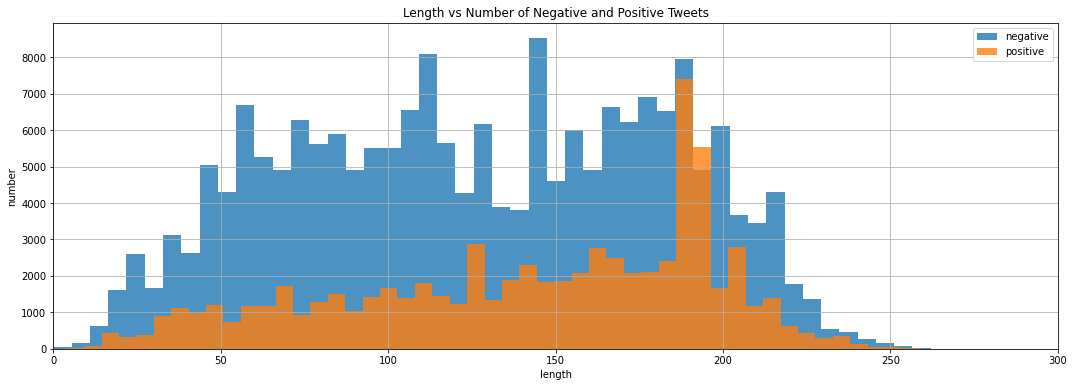

In [ ]:
# Plot the length vs number of negative and positive tweets
ukraine_df1['length'] = ukraine_df1['text'].apply(lambda x: len(x))
plt.figure(figsize=(18,6))
plt.hist(ukraine_df1[ukraine_df1['label']==0]['length'], alpha=0.8, bins=50, label='negative')
plt.hist(ukraine_df1[ukraine_df1['label']==1]['length'], alpha=0.8, bins=50, label='positive')
plt.xlabel('length')
plt.ylabel('number')
plt.title('Length vs Number of Negative and Positive Tweets')
plt.legend()
plt.xlim(0, 300)
plt.grid()
plt.show()

Wordclouds of negative and positive tweets.

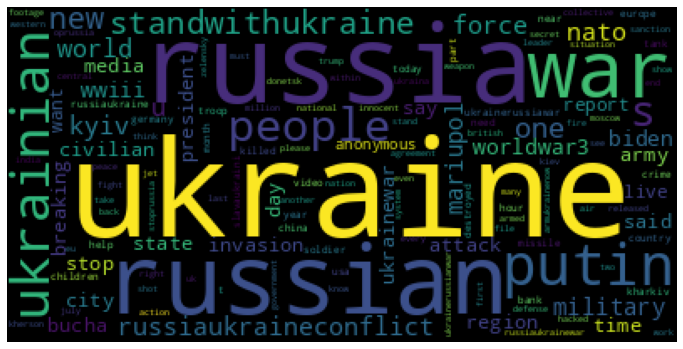

In [ ]:
# Plot the negative word cloud
plot_word_cloud(ukraine_df1, 0)

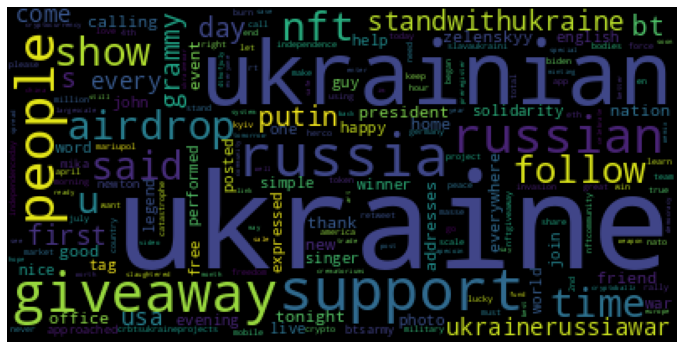

In [ ]:
# Plot the positive word cloud
plot_word_cloud(ukraine_df1, 1)

Top 10 negative and positive tweets.

In [ ]:
# Find out the probability of each tweet
probs = logistic_model.predict_proba(ukraine_df1_tfidf)
neg_probs = probs[:,0]
pos_probs = probs[:,1]

In [ ]:
n = 10
# Top n negative tweets
sorted_index = np.argsort(neg_probs)[-n:]
top_neg = ukraine_df1.text.reset_index(drop=True)[sorted_index]
print('Top {0} negative tweets: \n'.format(n))
for i in range(n):
  print(str(top_neg.index[i])+ ':  ' + top_neg.values[i])

Top 10 negative tweets: 

146664:  mariupols mayor puts dead 5000 civilians ukraine ukrainians russianwarcrimes putinswarcrimes putin dont foxnews stupid tuckercarlsonrussianasset
107755:  problem mental sickness hedonism unlike physical disease doesnt kill abuser kills injures around sick person gets stronger mentalhealth abuseofpower war
200914:  hate fucking motherland russia standwithukraine
161385:  dreadful images civilians killed buchamassacre ukraine russian army shocking everything must done independent investigation horrible crimes nothing ever excuse cruelty pain shame
262522:  standwithukraine dirtybiblethumpers religion spiritsarewatching truth northamerica attack onthisday normalization hate fear famine death
65505:  borysromanchenkoa 96year old holocaust survivor died apartment kharkiv hit russianarmy artillery sad survive nazi concentrationcamps die russian hate jewish israeli kharkivmassacre ukraineunderattack russianwarcrimes
164005:  putin invade ukraine would russia

In [ ]:
# Top n positive tweets
sorted_index = np.argsort(pos_probs)[-n:]
top_pos = ukraine_df1.text.reset_index(drop=True)[sorted_index]
print('Top {0} positive tweets: \n'.format(n))
for i in range(n):
  print(str(top_pos.index[i])+ ':  ' + top_pos.values[i])

Top 10 positive tweets: 

195839:  beautiful rendition happy 4th slavaukraini
202246:  happy birthday america wethepeople celebrate historic day independence laughter family bbqs beautiful firework displays hears independence wonderful liberties great country god bless usa happy july 4th patriots
123232:  good project thats really fantastic amazing project happy become part event thanks opportunity atr bitmart airdrop atr giveaway
61815:  amazing awesome unbelievable show bravery slavaukraini
254850:  great countrys thank europe tank usacanada standwithukraine slavaukraini
198361:  thank great thread summary glory slavaukraini
137959:  thank wonderful coverage fundraiser humanitarian aid grateful w ukraine
260653:  happy ukrainian independence day brickmania via amazing slavaukraini fckptn armukrainenow fckafd
193682:  happy 4th july awesome standwithukraine independenceday2022 independenceday
115214:  good great amazing standwithukraine


The number and percentage of negative and positive tweets.

In [ ]:
# Count the number of negative and positive tweets
ukraine_df1_count = ukraine_df1.groupby(['date', 'label']).size().reset_index(name='count')
neg_counts = ukraine_df1_count[ukraine_df1_count['label']==0].drop(['label'], axis=1)
pos_counts = ukraine_df1_count[ukraine_df1_count['label']==1].drop(['label'], axis=1)
ukraine_df1_count = pd.merge(neg_counts, pos_counts, on='date')
ukraine_df1_count = ukraine_df1_count.set_index('date')
ukraine_df1_count.columns = ['neg_counts', 'pos_counts']

ukraine_df1_count['total'] = ukraine_df1_count['neg_counts'] + ukraine_df1_count['pos_counts']
ukraine_df1_count['neg_per'] = ukraine_df1_count['neg_counts']/ukraine_df1_count['total']
ukraine_df1_count['pos_per'] = ukraine_df1_count['pos_counts']/ukraine_df1_count['total']

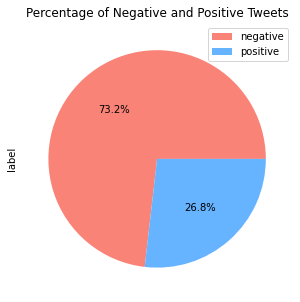

In [ ]:
colors = ['#fa8378','#66b3ff']
ukraine_df1['label'].value_counts().plot.pie(labeldistance=None, autopct='%1.1f%%', colors=colors, figsize=(5,5))
plt.title('Percentage of Negative and Positive Tweets')
plt.legend(['negative', 'positive'])
plt.show()

The change of negative and positive tweets through time.

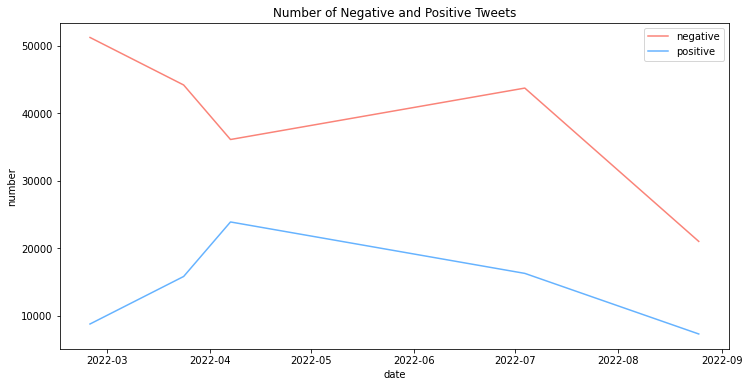

In [ ]:
ukraine_df1_count[['neg_counts', 'pos_counts']].plot(figsize=(12,6), color=['#fa8378','#66b3ff'])
plt.xlabel('date')
plt.ylabel('number')
plt.title('Number of Negative and Positive Tweets')
plt.legend(['negative', 'positive'])
plt.show()

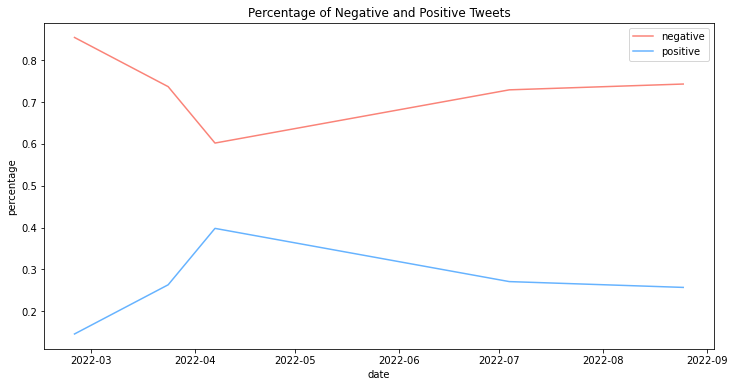

In [ ]:
ukraine_df1_count[['neg_per', 'pos_per']].plot(figsize=(12,6), color=['#fa8378','#66b3ff'])
plt.xlabel('date')
plt.ylabel('percentage')
plt.title('Percentage of Negative and Positive Tweets')
plt.legend(['negative', 'positive'])
plt.show()

## Reddit Posts about Russian Invasion of Ukraine

Posts and comments surrounding Reddit about Russia's Invasion of Ukraine.

https://www.kaggle.com/datasets/gpreda/russian-invasion-of-ukraine

In [ ]:
ukraine_df2 = pd.read_csv('russian_invasion_of_ukraine.csv', lineterminator='\n')
ukraine_df2 = ukraine_df2.dropna(subset=['body'])[['body', 'timestamp']]
ukraine_df2 = ukraine_df2.rename(columns={'body': 'text'})
ukraine_df2 = clean_data(ukraine_df2)

In [ ]:
# Read the date of each youtube comments, and sort
ukraine_df2['date'] = pd.to_datetime(ukraine_df2['timestamp']).dt.date
ukraine_df2 = ukraine_df2[['date', 'text']].sort_values(by=['date']).reset_index(drop=True)

In [ ]:
# Use the logistic_model we get from part1 to predict the sentiment label
ukraine_df2_text = ukraine_df2['text'].values.tolist()
ukraine_df2_tfidf = tfidf_vectorizer.transform(ukraine_df2_text)
model_pred = logistic_model.predict(ukraine_df2_tfidf)
ukraine_df2['label'] = model_pred

The length vs number of negative and positive reddit comments.

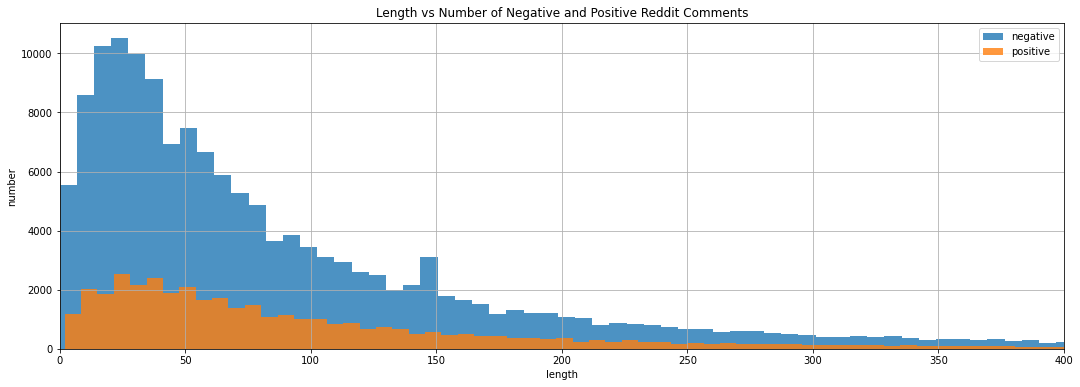

In [ ]:
# Plot the length vs number of negative and positive reddit comments
ukraine_df2['length'] = ukraine_df2['text'].apply(lambda x: len(x))
plt.figure(figsize=(18,6))
plt.hist(ukraine_df2[ukraine_df2['label']==0]['length'], alpha=0.8, bins=1000, label='negative')
plt.hist(ukraine_df2[ukraine_df2['label']==1]['length'], alpha=0.8, bins=1000, label='positive')
plt.xlabel('length')
plt.ylabel('number')
plt.title('Length vs Number of Negative and Positive Reddit Comments')
plt.legend()
plt.xlim(0, 400)
plt.grid()
plt.show()

Wordclouds of negative and positive reddit comments.

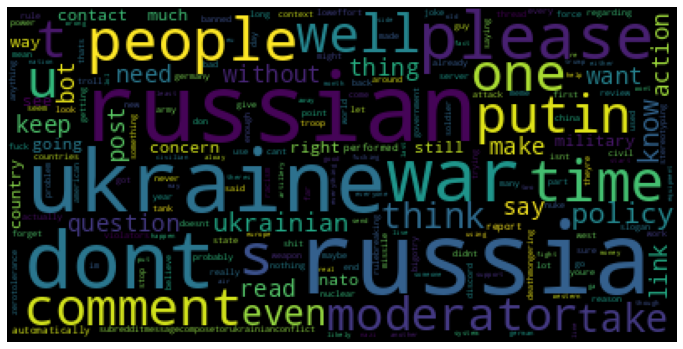

In [ ]:
# Plot the negative word cloud
plot_word_cloud(ukraine_df2, 0)

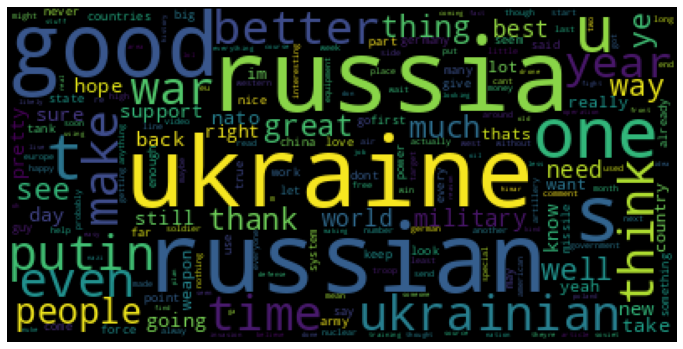

In [ ]:
# Plot the positive word cloud
plot_word_cloud(ukraine_df2, 1)

Top 10 negative and positive reddit comments.

In [ ]:
# Find out the probability of each reddit comments
probs = logistic_model.predict_proba(ukraine_df2_tfidf)
neg_probs = probs[:,0]
pos_probs = probs[:,1]

In [ ]:
n = 10
# Top n negative reddit comments
sorted_index = np.argsort(neg_probs)[-n:]
top_neg = ukraine_df2.text.reset_index(drop=True)[sorted_index]
print('Top {0} negative reddit comments: \n'.format(n))
for i in range(n):
  print(str(top_neg.index[i])+ ':  ' + top_neg.values[i])

Top 10 negative reddit comments: 

149182:  sad ukraine suffer worst losses tragic aggression vichnaya pamyat
65048:  ruski bitches putin ass fucked tiny dick everything make everyone angry boost ua morale wants war 70 year old fuck lost fucking mind puppets scared put bullet crossed eyes makes hate russians dont outspoke loudly condemn russia war die fuck war
176116:  typical russia blame problems everyone else russia worst enemy
39168:  sad bad
136411:  sad bad next
30376:  bad sad
192658:  deeply sad terrible sacrifice last defiant act killed wouldnt kill others fuck government hope remembered fondly sides conscientious objector back wall
30930:  casualties ukrainian army growing fucking hate russia it’s sick people
58800:  go fuck stupid racist
35440:  get tired sad angry bloody morons


In [ ]:
# Top n positive reddit comments
sorted_index = np.argsort(pos_probs)[-n:]
top_pos = ukraine_df2.text.reset_index(drop=True)[sorted_index]
print('Top {0} positive reddit comments: \n'.format(n))
for i in range(n):
  print(str(top_pos.index[i])+ ':  ' + top_pos.values[i])

Top 10 positive reddit comments: 

154738:  i’m happy could entertain
69840:  well russia happy take
113404:  kadyrov happy
106358:  slava ukraini happy 4th
113636:  happy 4th july
110076:  yup russia back 17th century czar peter happy
101320:  clearly happy logistics
196480:  great thank
73023:  great comment informative thank
186853:  love happy ending


The number and percentage of negative and positive reddit comments.

In [ ]:
# Count the number of negative and positive reddit comments
ukraine_df2_count = ukraine_df2.groupby(['date', 'label']).size().reset_index(name='count')
neg_counts = ukraine_df2_count[ukraine_df2_count['label']==0].drop(['label'], axis=1)
pos_counts = ukraine_df2_count[ukraine_df2_count['label']==1].drop(['label'], axis=1)
ukraine_df2_count = pd.merge(neg_counts, pos_counts, on='date')
ukraine_df2_count = ukraine_df2_count.set_index('date')
ukraine_df2_count.columns = ['neg_counts', 'pos_counts']

ukraine_df2_count['total'] = ukraine_df2_count['neg_counts'] + ukraine_df2_count['pos_counts']
ukraine_df2_count['neg_per'] = ukraine_df2_count['neg_counts']/ukraine_df2_count['total']
ukraine_df2_count['pos_per'] = ukraine_df2_count['pos_counts']/ukraine_df2_count['total']

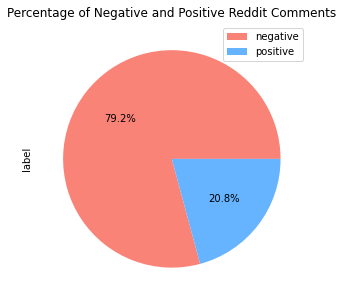

In [ ]:
colors = ['#fa8378','#66b3ff']
ukraine_df2['label'].value_counts().plot.pie(labeldistance=None, autopct='%1.1f%%', colors=colors, figsize=(5,5))
plt.title('Percentage of Negative and Positive Reddit Comments')
plt.legend(['negative', 'positive'])
plt.show()

The change of negative and positive reddit comments through time.

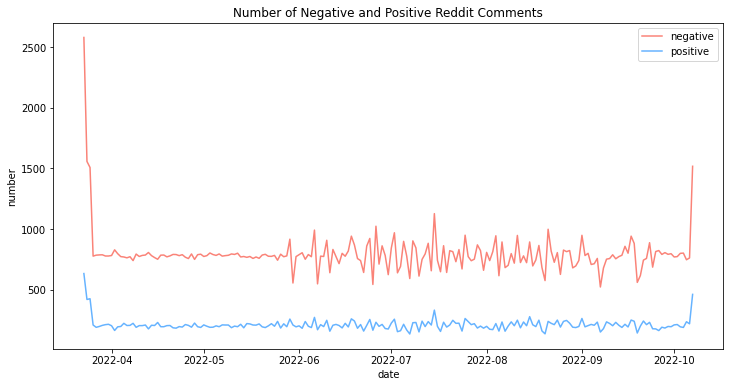

In [ ]:
ukraine_df2_count[['neg_counts', 'pos_counts']].plot(figsize=(12,6), color=['#fa8378','#66b3ff'])
plt.xlabel('date')
plt.ylabel('number')
plt.title('Number of Negative and Positive Reddit Comments')
plt.legend(['negative', 'positive'])
plt.show()

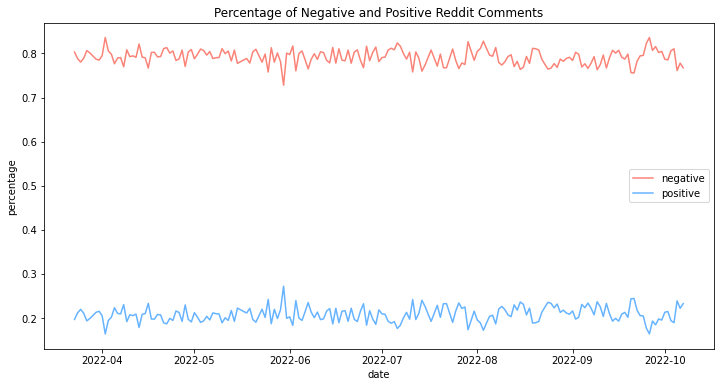

In [ ]:
ukraine_df2_count[['neg_per', 'pos_per']].plot(figsize=(12,6), color=['#fa8378','#66b3ff'])
plt.xlabel('date')
plt.ylabel('percentage')
plt.title('Percentage of Negative and Positive Reddit Comments')
plt.legend(['negative', 'positive'])
plt.show()

## Russia Ukraine war youtube discussion

Youtube video comments on the Russia-Ukraine war.

https://www.kaggle.com/datasets/anjalichawda/russia-ukraine-war-youtube-discussion

In [ ]:
ukraine_df3 = pd.read_csv('russia_ukraine_war_discussion.csv', lineterminator='\n')
ukraine_df3 = ukraine_df3.rename(columns={'Comments': 'text'})
ukraine_df3 = clean_data(ukraine_df3)
ukraine_df3 = ukraine_df3[['text', 'Likes']].sort_values(by=['Likes'], ascending=False).reset_index(drop=True)

In [ ]:
# Use the logistic_model we get from part1 to predict the sentiment label
ukraine_df3_text = ukraine_df3['text'].values.tolist()
ukraine_df3_tfidf = tfidf_vectorizer.transform(ukraine_df3_text)
model_pred = logistic_model.predict(ukraine_df3_tfidf)
ukraine_df3['label'] = model_pred

The length vs number of negative and positive youtube comments.

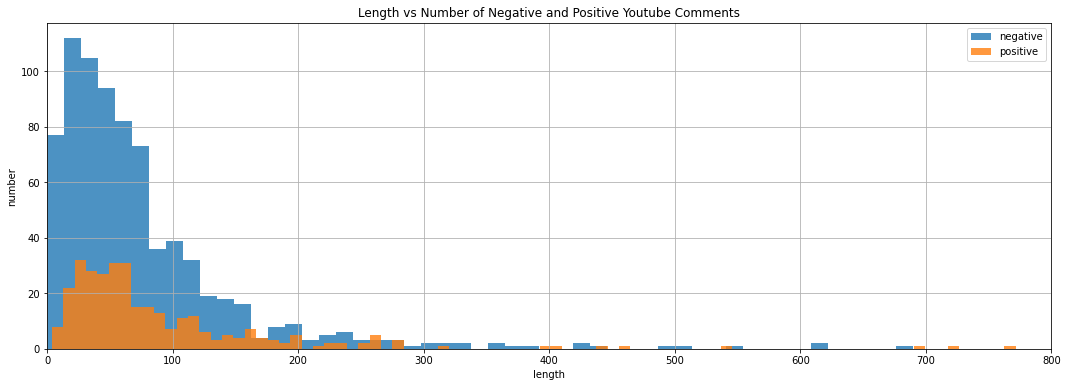

In [ ]:
# Plot the length vs number of negative and positive youtube comments
ukraine_df3['length'] = ukraine_df3['text'].apply(lambda x: len(x))
plt.figure(figsize=(18,6))
plt.hist(ukraine_df3[ukraine_df3['label']==0]['length'], alpha=0.8, bins=10000, label='negative')
plt.hist(ukraine_df3[ukraine_df3['label']==1]['length'], alpha=0.8, bins=100, label='positive')
plt.xlabel('length')
plt.ylabel('number')
plt.title('Length vs Number of Negative and Positive Youtube Comments')
plt.legend()
plt.xlim(0, 800)
plt.grid()
plt.show()

Wordclouds of negative and positive youtube comments.

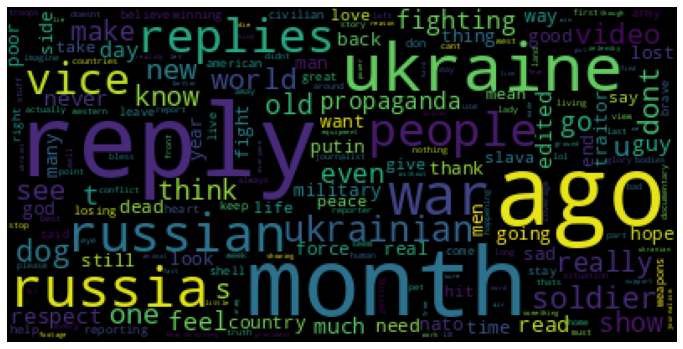

In [ ]:
# Plot the negative word cloud
plot_word_cloud(ukraine_df3, 0)

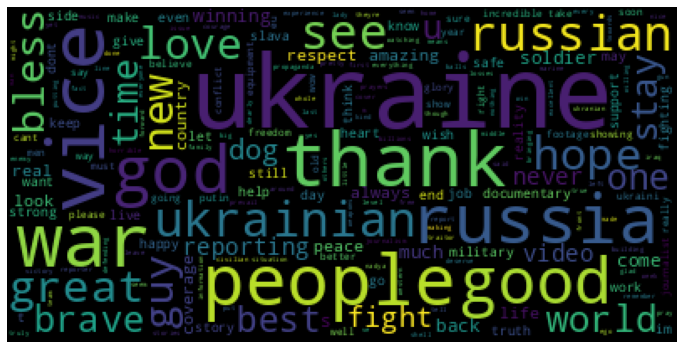

In [ ]:
# Plot the positive word cloud
plot_word_cloud(ukraine_df3, 1)

Top 10 negative and positive youtube comments.

In [ ]:
# Find out the probability of each youtube comments
probs = logistic_model.predict_proba(ukraine_df3_tfidf)
neg_probs = probs[:,0]
pos_probs = probs[:,1]

In [ ]:
n = 10
# Top n negative youtube comments
sorted_index = np.argsort(neg_probs)[-n:]
top_neg = ukraine_df3.text.reset_index(drop=True)[sorted_index]
print('Top {0} negative youtube comments: \n'.format(n))
for i in range(n):
  print(str(top_neg.index[i])+ ':  ' + top_neg.values[i])

Top 10 negative youtube comments: 

989:  serious question really hundred meters front line go attack right happens press personnel hit killed don’t mean purpose like cross fire artillery kills one
863:  wondering many ukrainian benn killed
684:  feel bad people animals ukrainian people ukrainian died animal died got lose isn’t little’s dog fault force go ukrainian
403:  sad ukraine shows compassion towards dead russian soldiers russian army alive
768:  sad
940:  sad vice provides one perspective
108:  sad see
520:  sad
116:  dont pet traitor worst punishment russian mre
515:  wonder smell worse dead alive


In [ ]:
# Top n positive youtube comments
sorted_index = np.argsort(pos_probs)[-n:]
top_pos = ukraine_df3.text.reset_index(drop=True)[sorted_index]
print('Top {0} positive youtube comments: \n'.format(n))
for i in range(n):
  print(str(top_pos.index[i])+ ':  ' + top_pos.values[i])

Top 10 positive youtube comments: 

444:  thank brve reporting dangerous situations
124:  thank footage
80:  great reportage thank journalists job glory ukraine
641:  vice back best happy see russian thank alternative view point
596:  vice back best happy see russian thank alternative view point
627:  incredible journalism thank
170:  great reportingpactric lancaster also great workthanks
987:  great see vice good journalism
38:  love vice type reports isis documentaries best they’ve reporting ukraine since russian invasion crimea
619:  great reporting thank vice


The number and percentage of negative and positive youtube comments.

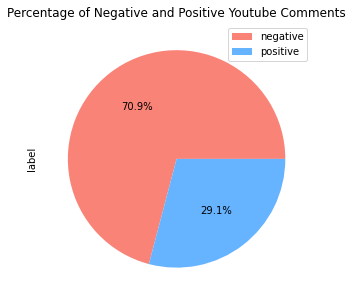

In [ ]:
colors = ['#fa8378','#66b3ff']
ukraine_df3['label'].value_counts().plot.pie(labeldistance=None, autopct='%1.1f%%', colors=colors, figsize=(5,5))
plt.title('Percentage of Negative and Positive Youtube Comments')
plt.legend(['negative', 'positive'])
plt.show()

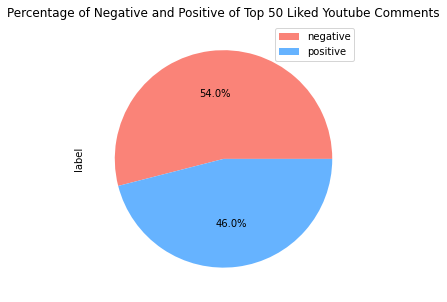

In [ ]:
colors = ['#fa8378','#66b3ff']
ukraine_df3.head(50)['label'].value_counts().plot.pie(labeldistance=None, autopct='%1.1f%%', colors=colors, figsize=(5,5))
plt.title('Percentage of Negative and Positive of Top 50 Liked Youtube Comments')
plt.legend(['negative', 'positive'])
plt.show()

## Using pre-trained NLP model (vader) on youtube comments

In [ ]:
ukraine_youtube = pd.read_csv('russia_ukraine_war_discussion.csv', lineterminator='\n')
ukraine_youtube = ukraine_youtube.rename(columns={'Comments': 'text'})
ukraine_youtube = clean_data(ukraine_youtube)
ukraine_youtube = ukraine_youtube[['text', 'Likes']].sort_values(by=['Likes'], ascending=False).reset_index(drop=True)
ukraine_youtube = ukraine_youtube[ukraine_youtube.text != '']

In [ ]:
def sentiment_vader(sentence):
  sid_obj = SentimentIntensityAnalyzer()
  sentiment_dict = sid_obj.polarity_scores(sentence)
  compound = sentiment_dict['compound']
  if compound >= 0:
    overall_sentiment = 1
  else :
    overall_sentiment = 0
  return overall_sentiment, compound

In [ ]:
vader_pred = ukraine_youtube['text'].apply(sentiment_vader)
ukraine_vader = ukraine_youtube.copy()
ukraine_vader['label'] = [label for label, compound in vader_pred.values]
ukraine_vader['compound'] = [compound for label, compound in vader_pred.values]

Wordclouds of negative and positive youtube comments (VADER).

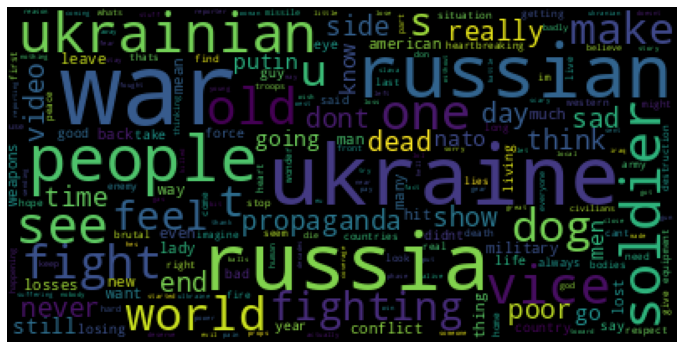

In [ ]:
# Plot the negative word cloud
plot_word_cloud(ukraine_vader, 0)

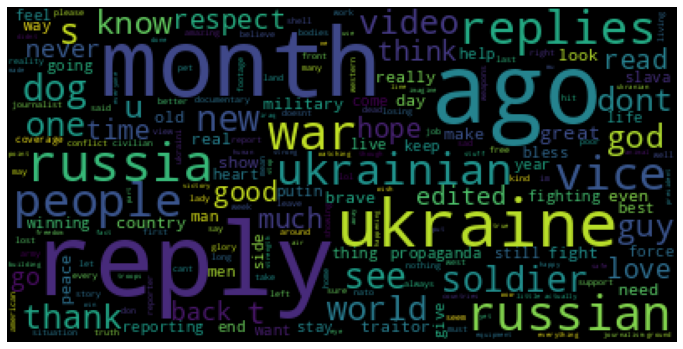

In [ ]:
# Plot the positive word cloud
plot_word_cloud(ukraine_vader, 1)

Top 10 negative and positive youtube comments.

In [ ]:
n = 10
# Top n negative youtube comments
neg_comments = ukraine_vader.sort_values(by='compound', ascending=True)
top_neg = neg_comments.head(n).text
print('Top {0} negative youtube comments: \n'.format(n))
for i in range(n):
  print(str(top_neg.index[i])+ ':  ' + top_neg.values[i])

Top 10 negative youtube comments: 

943:  american used think russians misunderstood mislead since war started though changed opinion entirely feel loathsome disgust hatred toward russians soldiers opportunities defect lies told putin plain site front eyes soldiers choosing believe lies deserve die feel pain saying feel pain ukrainians done power maintain create peace russian people chosen war whether choice cowardice ignorance matter russians pay deserve sympathy putin eventually face end streets hands people happens able feel sympathy equal reparations make people theyve murdered raped
1006:  world war iii begun unfolds depends us think russiaukraine war local conflict much global war multiple fronts war military conflict also economic war attrition skyrocketing gas prices shortage staples people world feeling consequences war
258:  quarter fighting force get time google look see many soldiers supposed russia come back video listen man tell 25 fighting force supposed deadmaybe means 

In [ ]:
# Top n positive youtube comments
pos_comments = ukraine_vader.sort_values(by='compound', ascending=False)
top_pos = pos_comments.head(n).text
print('Top {0} positive youtube comments: \n'.format(n))
for i in range(n):
  print(str(top_pos.index[i])+ ':  ' + top_pos.values[i])

Top 10 positive youtube comments: 

1073:  sg skip navigation sign vicenews news new phase war ukraine vice news 824m subscribers subscribe 80k share 37m views 4 months ago actually winning war ukraine changed almost weekly five months ago russia’s invasion ukraine looked different putin launched threeprong nationwide assault raining cruise missiles surrounding capital taking small villages towns quickly ukrainian forces held … show pico xr ad learn 3046 inside battle taiwan chinas looming war threat 60 minutes australia 60 minutes australia 407k views 2 days ago new 1644 ukraine war hell thats lysychansk sky news 903k views 4 months ago 2204 vice international s1 e83 control ukraines rogue militias vice 10m views 4 years ago 2826 cocaine washing fiji’s beaches turning paradise drug sbs dateline sbs dateline 43k views 17 hours ago new 605 ukraine war russian frontline soldiers shot retreating sky news 1m views 16 hours ago new 4407 life talibans afghanistan vice news 85m views 8 months

The number and percentage of negative and positive youtube comments.

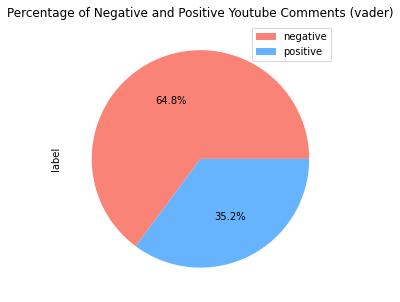

In [ ]:
colors = ['#fa8378','#66b3ff']
ukraine_vader['label'].value_counts().plot.pie(labeldistance=None, autopct='%1.1f%%', colors=colors, figsize=(5,5))
plt.title('Percentage of Negative and Positive Youtube Comments (vader)')
plt.legend(['negative', 'positive'])
plt.show()

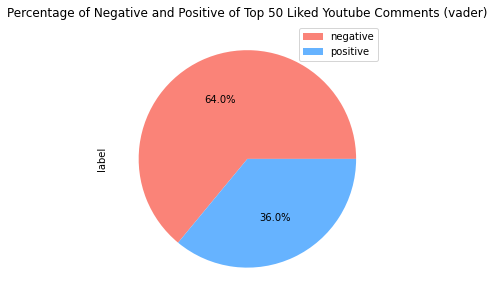

In [ ]:
colors = ['#fa8378','#66b3ff']
ukraine_vader.head(50)['label'].value_counts().plot.pie(labeldistance=None, autopct='%1.1f%%', colors=colors, figsize=(5,5))
plt.title('Percentage of Negative and Positive of Top 50 Liked Youtube Comments (vader)')
plt.legend(['negative', 'positive'])
plt.show()

## Using pre-trained NLP model (flair) on youtube comments

In [ ]:
def sentiment_flair(sentence):
  s = flair.data.Sentence(sentence)
  flair_sentiment.predict(s)
  sentiment = s.labels[0].to_dict()['value']
  confidence = s.labels[0].to_dict()['confidence']
  if sentiment == 'POSITIVE':
    overall_sentiment = 1
  else :
    overall_sentiment = 0
  return overall_sentiment, confidence

In [ ]:
flair_pred = ukraine_youtube['text'].apply(sentiment_flair)
ukraine_flair = ukraine_youtube.copy()
ukraine_flair['label'] = [label for label, confidence in flair_pred.values]
ukraine_flair['confidence'] = [confidence for label, confidence in flair_pred.values]

Wordclouds of negative and positive youtube comments (FLAIR).

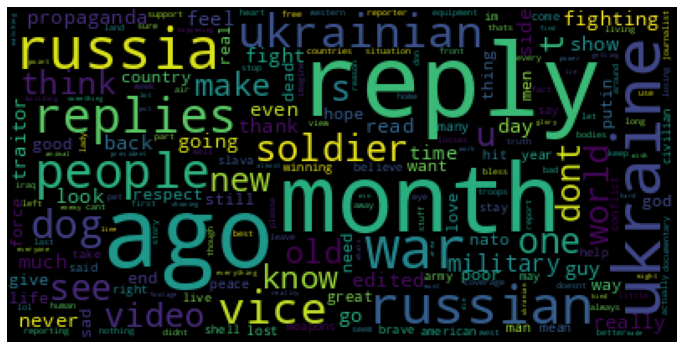

In [ ]:
# Plot the negative word cloud
plot_word_cloud(ukraine_flair, 0)

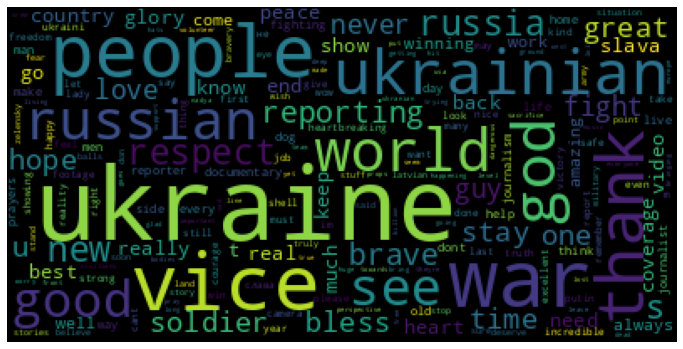

In [ ]:
# Plot the positive word cloud
plot_word_cloud(ukraine_flair, 1)

Top 10 negative and positive youtube comments.

In [ ]:
n = 10
# Top n negative youtube comments
neg_comments = ukraine_flair[ukraine_flair.label == 0].sort_values(by='confidence', ascending=False)
top_neg = neg_comments.head(n).text
print('Top {0} negative youtube comments: \n'.format(n))
for i in range(n):
  print(str(top_neg.index[i])+ ':  ' + top_neg.values[i])

Top 10 negative youtube comments: 

173:  cant imagine smell bodies swelling show much rotting
266:  stalemate ha ha ha video total propaganda start finish
503:  damn feel really bad old lady living alone people living alone like
579:  801 wow reporter wasnt lying looked like shell landed directly
697:  phase ukraine fired upon phase ii ukraine pushed back fortification we’re currently phase iii ukraine run crushed bits
1066:  holy crap looks like crap i’d see reddit absolutely brutal damn live terrible time always suppose
587:  imagine poor young man barely scrapping living day day hoping get lucky one day find better oppertunities moscow blink eye get conscripted war fight see platoon get cut half ordered toutter word happened dictators like putin start wars fought young hopeful men hope war ends soon
113:  poor dog looked shellshocked
43:  footage least month old leader carpathian sich kia last month underground bunker showed eventually destroyed sadly
412:  corpses lrp dpr


In [ ]:
# Top n positive youtube comments
pos_comments = ukraine_flair[ukraine_flair.label == 1].sort_values(by='confidence', ascending=False)
top_pos = pos_comments.head(n).text
print('Top {0} positive youtube comments: \n'.format(n))
for i in range(n):
  print(str(top_pos.index[i])+ ':  ' + top_pos.values[i])

Top 10 positive youtube comments: 

1084:  ukr winning video
474:  footage incredible props crew bringing us real news frontline
1015:  courage ukrainiens vous avez prouvé à la russie que vous nêtes pas petit vous êtes une puissance maintenant
769:  sound effect beginning
421:  bravo camera man
105:  footage bringing us closer war ever thanks risking life get amazing documentary
360:  footage bringing us closer war ever thanks risking life get amazing documentary
547:  wow short documentary powerful emotional
490:  bring back simon
716:  well done camera work clever usage music


The number and percentage of negative and positive youtube comments.

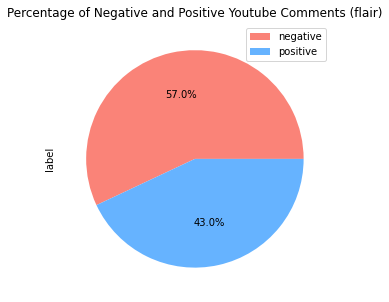

In [ ]:
colors = ['#fa8378','#66b3ff']
ukraine_flair['label'].value_counts().plot.pie(labeldistance=None, autopct='%1.1f%%', colors=colors, figsize=(5,5))
plt.title('Percentage of Negative and Positive Youtube Comments (flair)')
plt.legend(['negative', 'positive'])
plt.show()

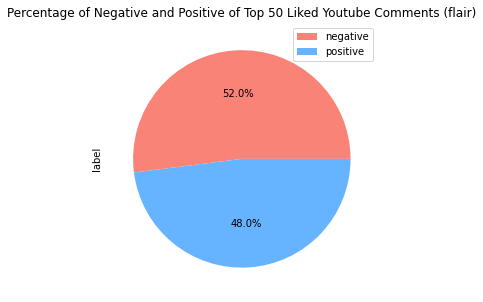

In [ ]:
colors = ['#fa8378','#66b3ff']
ukraine_flair.head(50)['label'].value_counts().plot.pie(labeldistance=None, autopct='%1.1f%%', colors=colors, figsize=(5,5))
plt.title('Percentage of Negative and Positive of Top 50 Liked Youtube Comments (flair)')
plt.legend(['negative', 'positive'])
plt.show()